In [1]:
import keras

Using Theano backend.
Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 5103)
/home/joakim/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [126]:
#path = "data/sample/"
path = "data/"
model_path = "model/second/"
batch_size=10

In [54]:
import utils; reload(utils)
from utils import *
import bcolz
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division, print_function
from keras.layers import Input, Dense
from keras.models import Model

I'll begin by making a sample of our dataset, so we can iterate over solutions more quickly than otherwise.

Doing a full pass of the training-data with a 80/20 split on my GTX 970 takes around 6-8 minutes, which is too long to actually experiment.

In [4]:
%ls

cats_vs_dogs_redux_first.ipynb   data/     utils.py*  vgg16bn.py*  vgg16.py*
cats_vs_dogs_redux_second.ipynb  results/  utils.pyc  vgg16bn.pyc  vgg16.pyc


In [14]:
import os, sys
%cd data
DATA_HOME_DIR = os.getcwd()
print(DATA_HOME_DIR)

/home/joakim/projects/KaggleDogsCatsRedux/data
/home/joakim/projects/KaggleDogsCatsRedux/data


In [7]:
%cd DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/joakim/projects/KaggleDogsCatsRedux/data


In [30]:
from shutil import copyfile
def execute_on_random_jpgs(directory, method, num_files):
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(num_files): method(shuf[i], '{}/{}'.format(directory, shuf[i]))

In [31]:
%cd $DATA_HOME_DIR/train/
#commented out to make sure I don't execute this several times by mistake
#execute_on_random_jpgs('{}/{}'.format(DATA_HOME_DIR, 'valid'), os.rename, 2000)

/home/joakim/projects/KaggleDogsCatsRedux/data/train


In [32]:
%cd $DATA_HOME_DIR/train/
#execute_on_random_jpgs('{}/{}'.format(DATA_HOME_DIR, 'sample/train'), copyfile, 250)
#execute_on_random_jpgs('{}/{}'.format(DATA_HOME_DIR, 'sample/valid'), copyfile, 75)

/home/joakim/projects/KaggleDogsCatsRedux/data/train


In [36]:
def move_dogs_cats(directory):
    %cd $directory
    %mkdir cats
    %mkdir dogs
    %mv cat.*.jpg cats/
    %mv dog.*.jpg dogs/

In [37]:
move_dogs_cats(DATA_HOME_DIR+"/sample/train")
move_dogs_cats(DATA_HOME_DIR+"/sample/valid")
move_dogs_cats(DATA_HOME_DIR+"/valid")
move_dogs_cats(DATA_HOME_DIR+"/train")

/home/joakim/projects/KaggleDogsCatsRedux/data/sample/train
mkdir: cannot create directory ‘cats’: File exists
mkdir: cannot create directory ‘dogs’: File exists
mv: cannot stat 'cat.*.jpg': No such file or directory
mv: cannot stat 'dog.*.jpg': No such file or directory
/home/joakim/projects/KaggleDogsCatsRedux/data/sample/valid
/home/joakim/projects/KaggleDogsCatsRedux/data/valid
/home/joakim/projects/KaggleDogsCatsRedux/data/train


In [38]:
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/joakim/projects/KaggleDogsCatsRedux/data/test


In [44]:
%cd ../..

/home/joakim/projects/KaggleDogsCatsRedux


In [101]:
size=(400,400)
batches = get_batches(path+'train', batch_size=batch_size, target_size=size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False, target_size=size)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [16]:
imgs,labels = next(batches)

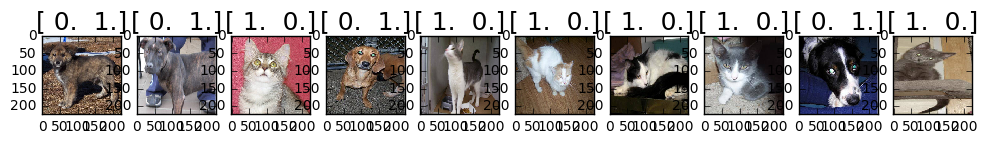

In [17]:
plots(imgs, titles=labels)

In [102]:
from vgg16bn import Vgg16BN
vgg = Vgg16BN(size)
model = vgg.model

/home/joakim/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_5 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 400, 400)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [6]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
#                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [61]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 3, 400, 400)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
zeropadding2d_27 (ZeroPadding2D) (None, 3, 402, 402)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_35 (Convolution2D) (None, 64, 400, 400)  1792        zeropadding2d_27[0][0]           
____________________________________________________________________________________________________
zeropadding2d_28 (ZeroPadding2D) (None, 64, 402, 402)  0           convolution2d_35[0][0]           
___________________________________________________________________________________________

In [103]:
nf=128; p=0.

In [104]:
#Set all layers to trainable=False, to freeze the top part of the model
for layer in model.layers: layer.trainable=False

In [105]:
lrg_model = Sequential()
lrg_model.add(model)
lrg_model.add(BatchNormalization(axis=1,))
lrg_model.add(Convolution2D(nf,3,3, activation='relu', border_mode='same'))
lrg_model.add(BatchNormalization(axis=1))
lrg_model.add(MaxPooling2D())
lrg_model.add(Convolution2D(nf,3,3, activation='relu', border_mode='same'))
lrg_model.add(BatchNormalization(axis=1))
lrg_model.add(MaxPooling2D())
lrg_model.add(Convolution2D(nf,3,3, activation='relu', border_mode='same'))
lrg_model.add(BatchNormalization(axis=1))
lrg_model.add(MaxPooling2D((1,2)))
lrg_model.add(Convolution2D(2,3,3, border_mode='same'))
lrg_model.add(Dropout(p))
lrg_model.add(GlobalAveragePooling2D())
lrg_model.add(Activation('softmax'))

In [106]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
sequential_10 (Sequential)       (None, 512, 12, 12)   14714688                                     
____________________________________________________________________________________________________
batchnormalization_21 (BatchNorm (None, 512, 12, 12)   2048        maxpooling2d_40[0][0]            
____________________________________________________________________________________________________
convolution2d_86 (Convolution2D) (None, 128, 12, 12)   589952      batchnormalization_21[0][0]      
____________________________________________________________________________________________________
batchnormalization_22 (BatchNorm (None, 128, 12, 12)   512         convolution2d_86[0][0]           
___________________________________________________________________________________________

In [107]:
lrg_model.compile(optimizer=Adam(1e-4),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.load_weights(path+'results/fully_convolutional_400_3.h5')

In [ ]:
lrg_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [13]:
model.save_weights(path+'results/fully_convolutional_400.h5')

In [31]:
lrg_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=2,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/2
250/250 [==============================] - 18s - loss: 0.0531 - acc: 0.9840 - val_loss: 0.3917 - val_acc: 0.9333

In [21]:
model.save_weights(path+'results/fully_convolutional_400_3.h5')

In [124]:
test_batches = get_batches(path+'test', batch_size=batch_size, shuffle=False, target_size=size, class_mode=None)

Found 12500 images belonging to 1 classes.


In [125]:
preds = lrg_model.predict_generator(test_batches, test_batches.nb_sample)

## Submit data
We're ready to submit our data to Kaggle, and will use these lines of codes to generate our submission.

In [127]:
print(preds[:5])

[[  9.9979e-01   2.0584e-04]
 [  8.0024e-05   9.9992e-01]
 [  9.9996e-01   3.7948e-05]
 [  8.5263e-08   1.0000e+00]
 [  9.6528e-01   3.4724e-02]]


In [128]:
isdog = preds[:,1]
#isdog = 1 - isdog
#tmp = isdog > 0.5
#isdog = tmp.astype(int)
isdog = isdog.clip(min=0.05, max=0.95)

In [129]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = test_batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [130]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  4.0680e+03,   5.0000e-02],
       [  5.9930e+03,   9.5000e-01],
       [  3.6040e+03,   5.0000e-02],
       [  7.2650e+03,   9.5000e-01],
       [  5.8700e+03,   5.0000e-02]])

In [131]:
submission_file_name = path + 'results/submission_fully_cnn4.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

## Dissapointing results
Our model is not getting the results we were hoping for given the reusults we saw in training/validation.

Maybe we should look at some things it's getting correct, and some things it's getting wrong? Maybe use a different evaluator.method?

In [132]:
val_batches = get_batches(path+'valid', batch_size=batch_size, shuffle=False, target_size=size, class_mode=None)

Found 2000 images belonging to 2 classes.


In [133]:
probs = lrg_model.predict_generator(val_batches, val_batches.nb_sample)

In [134]:
n_view = 4
filenames = val_batches.filenames
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

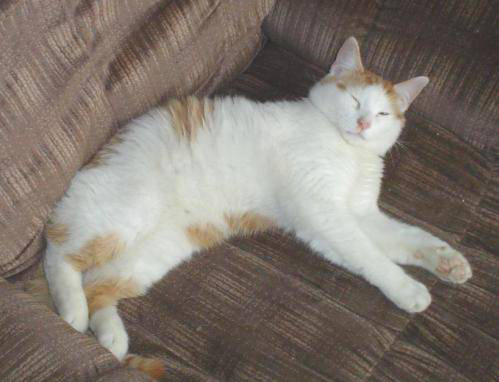

In [171]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(path+"valid/" + filenames[2])

In [135]:
expected_labels = val_batches.classes #0 or 1

In [136]:
num = 10
print(probs[:num])
print(expected_labels[:num])
print(filenames[:num])

[[  1.0000e+00   3.9726e-08]
 [  9.9955e-01   4.4987e-04]
 [  1.0000e+00   5.0062e-10]
 [  1.0000e+00   3.4745e-09]
 [  1.0000e+00   1.5539e-06]
 [  1.0000e+00   2.9830e-07]
 [  1.0000e+00   1.5637e-08]
 [  3.0614e-01   6.9386e-01]
 [  9.9998e-01   1.9409e-05]
 [  1.0000e+00   5.5987e-09]]
[0 0 0 0 0 0 0 0 0 0]
['cats/cat.2634.jpg', 'cats/cat.7737.jpg', 'cats/cat.9937.jpg', 'cats/cat.2094.jpg', 'cats/cat.2912.jpg', 'cats/cat.8152.jpg', 'cats/cat.2908.jpg', 'cats/cat.587.jpg', 'cats/cat.8641.jpg', 'cats/cat.4310.jpg']


In [137]:
our_predictions = probs[:,1]
tmp = our_predictions > 0.5
our_labels = tmp.astype(int)

Found 1965 correct labels


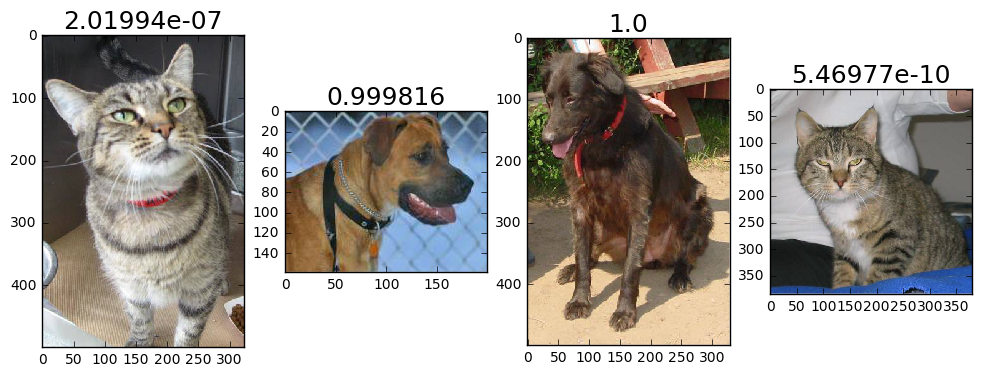

In [138]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print("Found %d correct labels" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 35 incorrect labels
[1308  694  456  709]


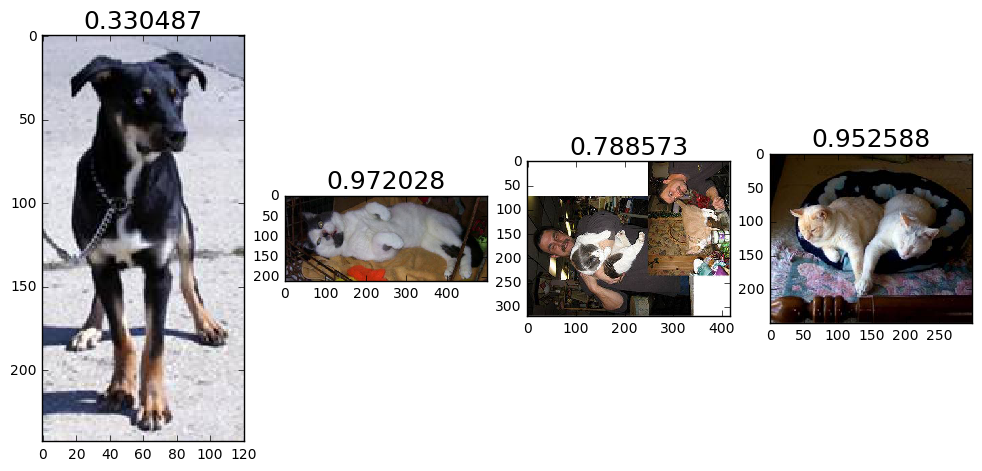

In [141]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print("Found %d incorrect labels" % len(incorrect))
idx = permutation(incorrect)[:n_view]
print(idx)
plots_idx(idx, our_predictions[idx])

Found 1008 confident correct cats labels


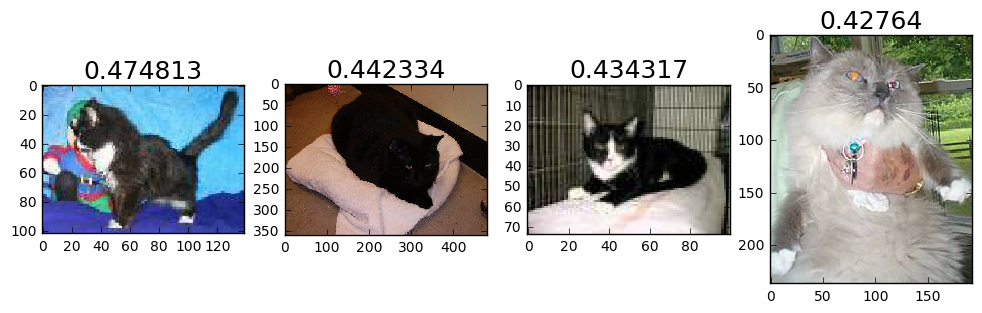

In [117]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print("Found %d confident correct cats labels" % len(correct_cats))
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 957 confident correct dogs labels


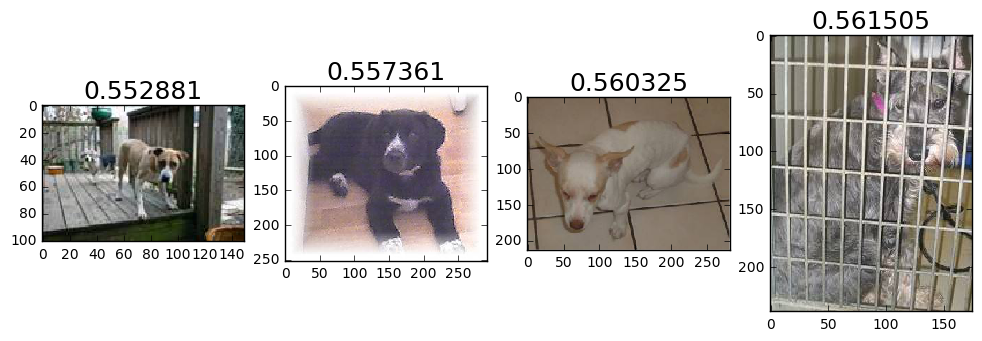

In [118]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print("Found %d confident correct dogs labels" % len(correct_dogs))
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 17 incorrect cats


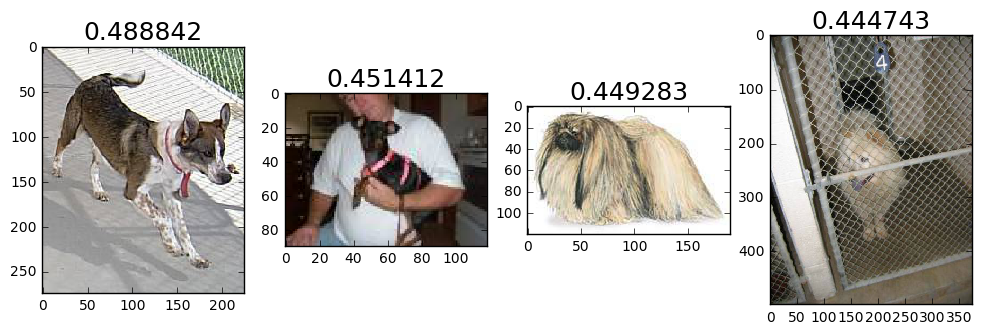

In [119]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print("Found %d incorrect cats" % len(incorrect_cats))
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 17 incorrect dogs


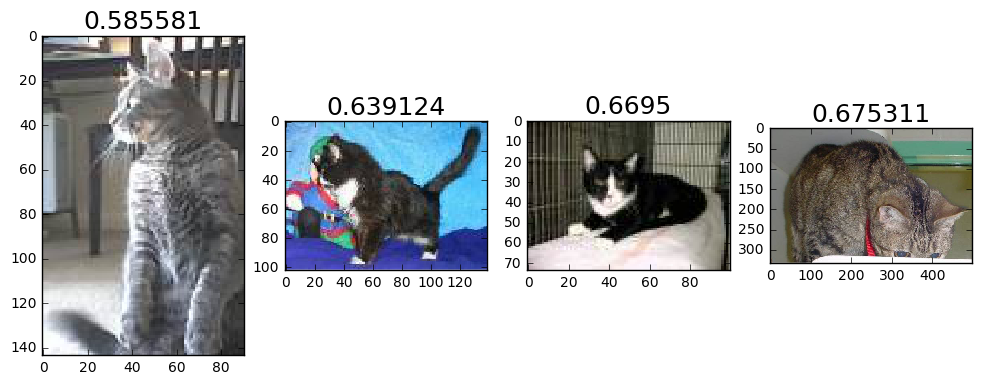

In [147]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print("Found %d incorrect dogs" % len(incorrect_dogs))
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

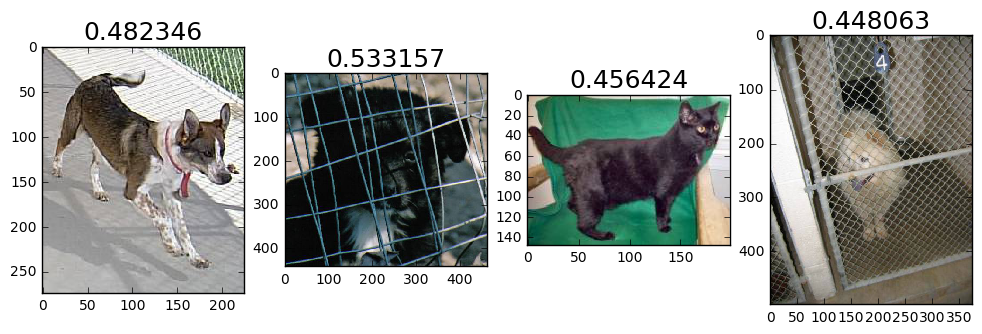

In [144]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

[[1009   17]
 [  18  956]]


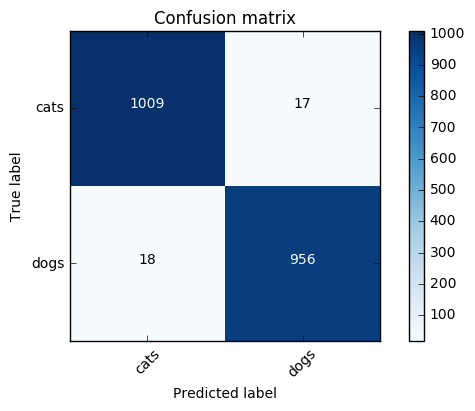

In [142]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, val_batches.class_indices)

In [200]:
batches.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)